In [1]:
import random
import pandas as pd
import nltk
from nltk.corpus import treebank
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import torch 
import torch.nn as nn
import torch.nn.functional as F 
from collections import OrderedDict
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import optim
import numpy as np 
import re
nltk.download('punkt')
nltk.download('treebank')
nltk.download('stopwords')
description_df = pd.read_csv('../dataset/binary_classifiers/description.csv')
installation_df = pd.read_csv('../dataset/binary_classifiers/installation.csv')
invocation_df = pd.read_csv('../dataset/binary_classifiers/invocation.csv')
citation_df = pd.read_csv('../dataset/binary_classifiers/citation.csv')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/charlesxin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package treebank to
[nltk_data]     /Users/charlesxin/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/charlesxin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# def lower_stopwords(x):
#     x = x.lower()
#     text_tokens = [word for word in word_tokenize(x) if word not in stopwords.words()]
#     return " ".join(text_tokens)
def lower_stopwords(x):
    x = re.sub(r'[^a-zA-Z\s]', '', x, re.I|re.A)
    x = x.lower()
    x = x.strip()
    text_tokens = [word for word in word_tokenize(x) if word not in stopwords.words()]
    return " ".join(text_tokens)

In [3]:
# print(description_df.groupby(by = "description").count())
# print(description_df.count())
# print(installation_df.count())
# print(invocation_df.count())
# print(citation_df.count())
print(description_df["excerpt"][6])

The original implementation is based on our internal Mxnet version. There are slight differences in the final accuracy and running time due to the plenty details in platform switch.


In [4]:
neg_quant = int(len(description_df) * .375)
treebank_background = pd.DataFrame(list(map(lambda sent: ' '.join(sent), random.sample(list(treebank.sents()), neg_quant))), columns=["excerpt"]).assign(description=False)
description_corpus = pd.concat([description_df.assign(description=True), installation_df.sample(neg_quant).assign(description=False), invocation_df.sample(neg_quant).assign(description=False), citation_df.sample(neg_quant).assign(description=False),treebank_background], sort=False)
description_corpus.drop('URL', 1, inplace=True)
description_corpus.dropna(0, inplace=True)
description_corpus.reset_index(drop=True, inplace=True)
description_corpus["excerpt"] = description_corpus["excerpt"].apply(lower_stopwords)

In [5]:
print(description_corpus.groupby(by = "description").count())


             contributor  excerpt
description                      
False                598      598
True                 545      545


In [6]:
X, y = description_corpus.excerpt, description_corpus.description
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix

In [8]:
def curtail(array,threshold = 0.0):
    return array * (array>=threshold)

In [9]:
bina = False
tf_idf = False 
threshold = 0.0
if(bina):
    if(tf_idf):
        vectorizer = TfidfVectorizer(use_idf=True,binary=True)
        X_vect_train = vectorizer.fit_transform(X_train).toarray()
        X_vect_train = curtail(X_vect_train,threshold)
        X_vect_test = vectorizer.transform(X_test).toarray()        
    else:
        vectorizer = CountVectorizer(binary=True)
        X_vect_train = vectorizer.fit_transform(X_train).toarray()
        X_vect_test =  vectorizer.transform(X_test).toarray()        
else:
    if(tf_idf):
        vectorizer = TfidfVectorizer(use_idf=True)
        X_vect_train = vectorizer.fit_transform(X_train).toarray()
        X_vect_train = curtail(X_vect_train,threshold)
        X_vect_test = vectorizer.transform(X_test).toarray()
    else:
        vectorizer = CountVectorizer()
        X_vect_train = vectorizer.fit_transform(X_train).toarray()
        X_vect_test =  vectorizer.transform(X_test).toarray()

y_hot_train = pd.get_dummies(y_train.values)
y_hot_test = pd.get_dummies(y_test.values)

class FFN(nn.Module):
    
    def __init__(self,layer_arch,input_size,output_size,bias = True):
        super(FFN,self).__init__()
        self.layer_arch = layer_arch
        self.input_size = input_size
        self.output_size = output_size
        self.bias = bias
        self.build_model()
        
    def build_model(self):
        model_arch = []
        unit = self.input_size
        for i,num in enumerate(self.layer_arch):
            model_arch.append(("dense_"+str(i), nn.Linear(unit,num,bias = self.bias)))
            model_arch.append(("nonlinear_"+str(i), nn.ReLU()))
            if(i==1 or i==3 or i==5):
                model_arch.append(("dropout_"+str(i), nn.Dropout()))
            unit = num
        model_arch.append(("dense_final",nn.Linear(unit,self.output_size,bias=self.bias)))
        model_arch.append(("act_final",nn.Sigmoid()))
        self.model = nn.Sequential(OrderedDict(model_arch))
    def forward(self,inputs):
        return self.model(inputs)
    

        

In [10]:
print(X_vect_train[2])
print(X_vect_test.shape)
print(X_train[155])

[0 0 0 ... 0 0 0]
(286, 3206)
mplstereonet provides lowerhemisphere equalarea equalangle stereonets matplotlib


In [11]:
model = FFN([256,1024,2048,1024,1024,512,256],X_vect_train.shape[1],2)
epoch_num = 30
bs = 300
history = []
train_ds = TensorDataset(torch.tensor(X_vect_train).float(), torch.tensor(y_hot_train.values).float())
train_dl = DataLoader(train_ds, batch_size=bs)
opt = optim.Adam(model.parameters())
for i in range(epoch_num):
    for xb,yb in train_dl:
        target = torch.argmax(yb,dim = 1,keepdim=False)
        pred = model(xb)
        loss_fun = nn.CrossEntropyLoss()
        loss = loss_fun(pred,target)
        loss.backward()
        opt.step()
        opt.zero_grad()        
    #### test metrics #####
    test_pred = model(torch.tensor(X_vect_test).float())
    
    test_pred = torch.argmax(test_pred,dim=1,keepdim=False)
    ground_truth = torch.argmax(torch.tensor(y_hot_test.values).float(),dim=1,keepdim=False)
    tn, fp, fn, tp = confusion_matrix(test_pred,ground_truth).ravel()
    
    ### precision ###
    precision = (tp/(tp+fp))*100
    ### recall ###
    recall = (tp/(tp+fn))*100
    ### F-measure ###
    F_measure = (2*precision*recall)/(precision+recall)
    ### accuracy ###
    accuracy = (torch.true_divide((torch.sum((test_pred-ground_truth)==0)),test_pred.shape[0]))*100
    print("test accuracy is {}".format(accuracy))
    print("test precision is {}".format(precision))
    print("test recall is {}".format(recall))
    print("test F-measure is {}".format(F_measure))
    print("************************")
    
    history.append({"accuracy":accuracy,"precision":precision,"recall":recall,"F_measure":F_measure})


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


test accuracy is 51.048954010009766
test precision is 0.0
test recall is nan
test F-measure is nan
************************
test accuracy is 51.048954010009766
test precision is 0.0
test recall is nan
test F-measure is nan
************************
test accuracy is 51.398597717285156
test precision is 0.7142857142857143
test recall is 100.0
test F-measure is 1.4184397163120568
************************
test accuracy is 80.06993103027344
test precision is 87.14285714285714
test recall is 75.77639751552795
test F-measure is 81.06312292358803
************************
test accuracy is 82.16783142089844
test precision is 88.57142857142857
test recall is 77.9874213836478
test F-measure is 82.94314381270904
************************
test accuracy is 83.91608428955078
test precision is 92.85714285714286
test recall is 78.3132530120482
test F-measure is 84.9673202614379
************************
test accuracy is 82.16783142089844
test precision is 95.71428571428572
test recall is 74.86033519553072


In [12]:
import matplotlib.pyplot as plt

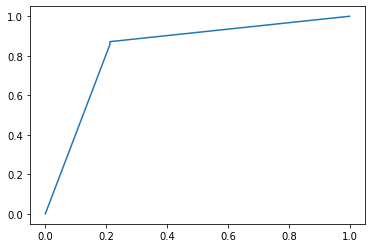

In [13]:

from sklearn import metrics
ground_truth = torch.argmax(torch.tensor(y_hot_test.values).float(),dim=1,keepdim=False)
test_pred_prob = model(torch.tensor(X_vect_test).float())
test_pred = torch.argmax(test_pred_prob,dim=1,keepdim=False)
fpr, tpr, thresholds = metrics.roc_curve(ground_truth.detach().numpy(), test_pred_prob[:,1].detach().numpy())
fig,ax = plt.subplots()
ax.plot(fpr,tpr)
plt.show()

In [14]:
n = len(history)
accu_array = np.array([history[i]["accuracy"] for i in range(n)])
prec_array = np.array([history[i]["precision"] for i in range(n)])
recall_array = np.array([history[i]["recall"] for i in range(n)])
F_array = np.array([history[i]["F_measure"] for i in range(n)])
np.save('../visualization/data/description_accu', accu_array)
np.save('../visualization/data/description_prec', prec_array)
np.save('../visualization/data/description_recall', recall_array)
np.save('../visualization/data/description_f', F_array)

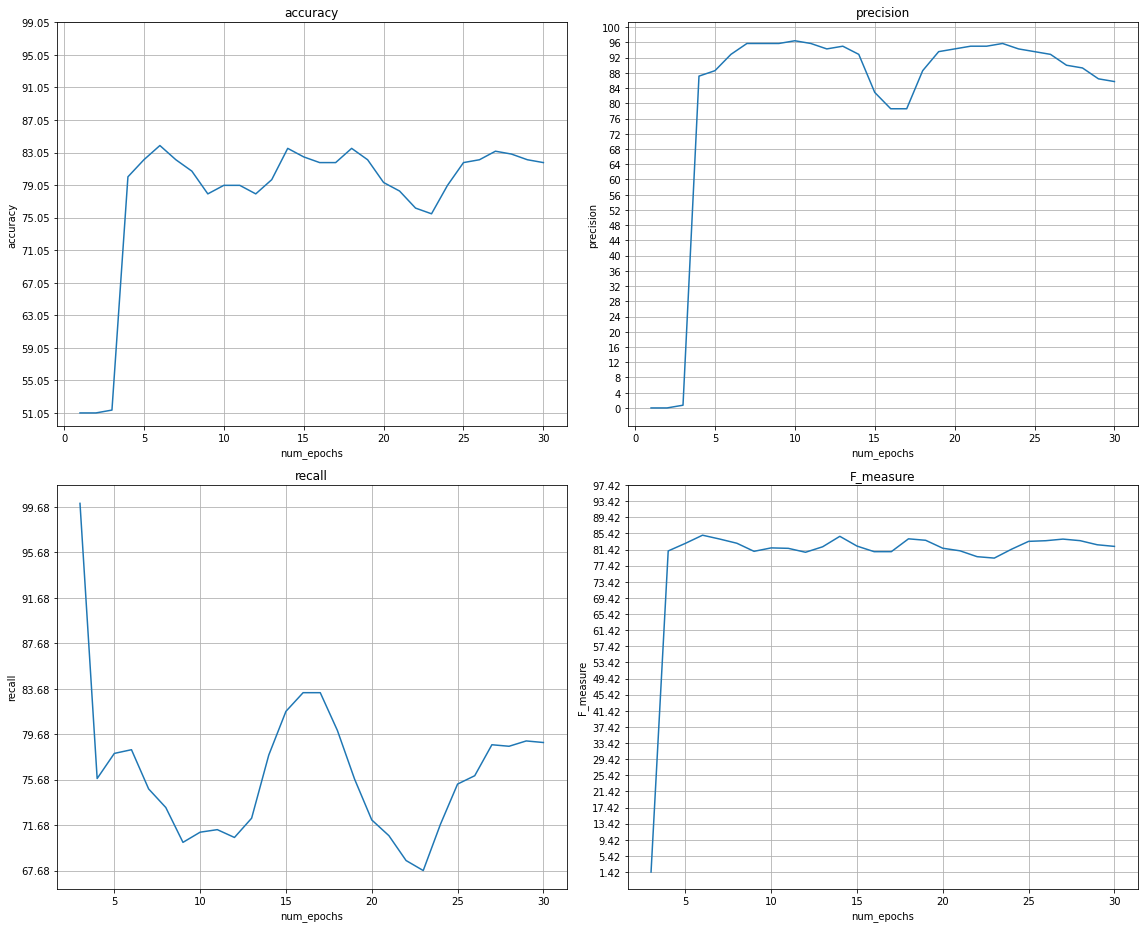

In [15]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(16, 13))
interval = 4

ax1.plot([i+1 for i in range(n)],accu_array)
ax1.set_xlabel("num_epochs")
ax1.set_ylabel("accuracy")
ax1.set_title("accuracy")
ax1.grid()
ax1.set_yticks([i for i in np.arange(min(accu_array[~np.isnan(accu_array)]),101,interval)])

ax2.plot([i+1 for i in range(n)],prec_array)
ax2.set_xlabel("num_epochs")
ax2.set_ylabel("precision")
ax2.set_title("precision")
ax2.grid()
ax2.set_yticks([i for i in np.arange(min(prec_array[~np.isnan(prec_array)]),101,interval)])

ax3.plot([i+1 for i in range(n)],recall_array)
ax3.set_xlabel("num_epochs")
ax3.set_ylabel("recall")
ax3.set_title("recall")
ax3.grid()
ax3.set_yticks([i for i in np.arange(min(recall_array[~np.isnan(recall_array)]),101,interval)])

ax4.plot([i+1 for i in range(n)],F_array)
ax4.set_xlabel("num_epochs")
ax4.set_ylabel("F_measure")
ax4.set_title("F_measure")
ax4.grid()
ax4.set_yticks([i for i in np.arange(min(F_array[~np.isnan(F_array)]),101,interval)])
plt.tight_layout()
plt.show()